# Load Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import zarr
import os
import einops
%load_ext autoreload

from transformers import ViTForImageClassification, ViTImageProcessor, ViTFeatureExtractor, ViTConfig, ViTModel, pipeline
from diffusers import AutoencoderKL
from torch.utils.data import DataLoader
from data_preprocessing import preprocess_images,XrdDataset

from utils import get_directories, get_imgs, get_device



/Users/yarongli/anaconda3/envs/deeplearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%autoreload 2

# Data Preparation

In [3]:
path = 'data'
directories = get_directories(path)[:1]
imgs_original,_ = get_imgs(directories)


original min 0.0
original max 1318.0


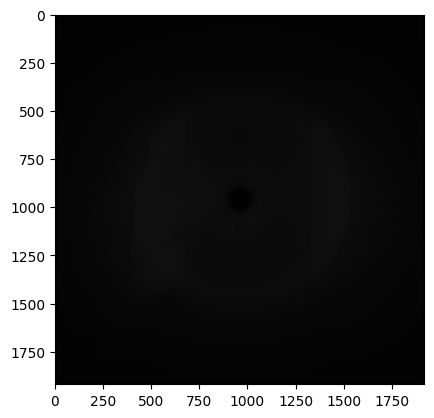

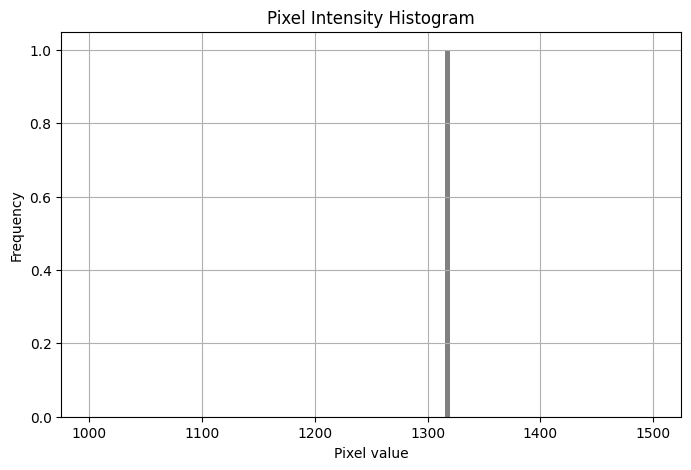

In [4]:
# Original image exploration
raw_image_test = imgs_original[0, :, :, 0]
raw_image_test[-10:, :] = 0
raw_image_test[:, -10:] = 0
raw_image_test[:10, :] = 0
raw_image_test[:, :10] = 0
plt.imshow(raw_image_test, cmap='gray')
print("original min", raw_image_test.min())
print("original max", raw_image_test.max())

def plot_pixel_histogram(img, bins=100, range=(1000, 1500)):
    if img.ndim == 3 and img.shape[-1] == 1:
        img = np.squeeze(img)
    plt.figure(figsize=(8, 5))
    plt.hist(img.ravel(), bins, range, color='gray')
    plt.title("Pixel Intensity Histogram")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_pixel_histogram(raw_image_test, bins=100, range=(1000, 1500))

min before normalization 0.0 max before normalization 65535.0
imgs shape (1920, 1920)
min 0.0
max 0.0


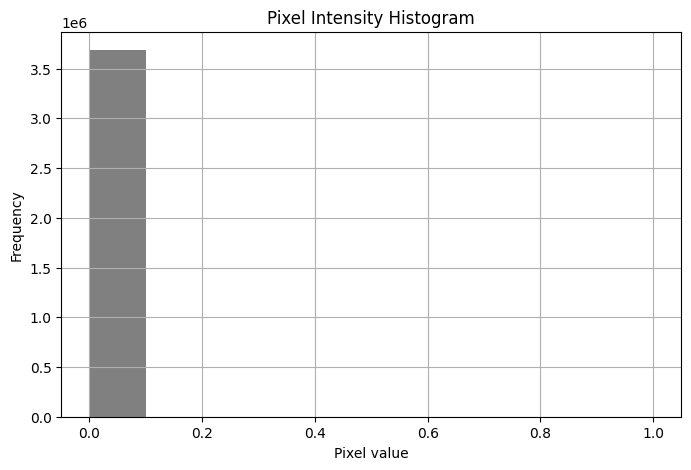

In [5]:
# Preprocessed images exploration
imgs = preprocess_images(imgs_original)
preprocessed_img = imgs[0, :, :, 0]
print("imgs shape", preprocessed_img.shape)
print("min", preprocessed_img.min())
print("max", preprocessed_img.max())
plot_pixel_histogram(preprocessed_img, bins=10, range=(0, 1))


torch.Size([1, 1, 240, 240])


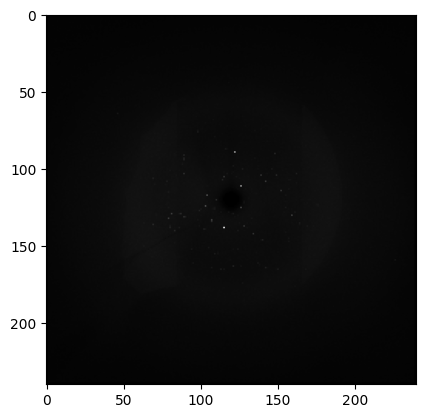

In [6]:
# Use Local Max pooling to downsample the image
import torch.nn.functional as F
raw_image_test_tensor = torch.from_numpy(raw_image_test).unsqueeze(0).unsqueeze(0)
downsampled = F.max_pool2d(raw_image_test_tensor, kernel_size=8, stride=8)

print(downsampled.shape)  # -> torch.Size([1, 1, 240, 240])
downsampled_np = downsampled.squeeze().numpy()
plt.imshow(downsampled_np, cmap='gray')

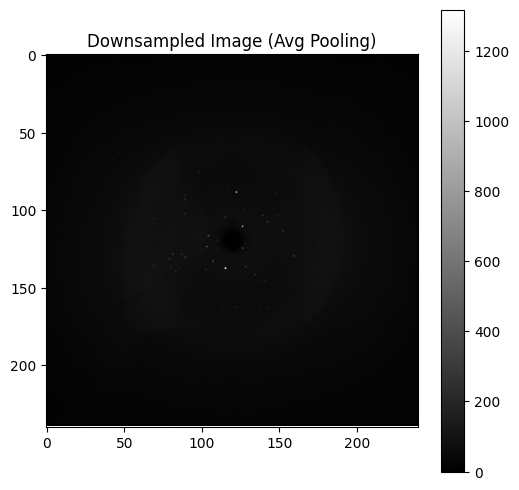

In [7]:
# Use Average pooling to downsample the image
import torch.nn.functional as F

raw_image_test_tensor = torch.from_numpy(raw_image_test).unsqueeze(0).unsqueeze(0)
factor = 8
downsampled_avg = F.avg_pool2d(raw_image_test_tensor, kernel_size=factor, stride=factor)
downsampled_np_avg = downsampled.squeeze().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(downsampled_np_avg, cmap='gray')
plt.title("Downsampled Image (Avg Pooling)")
plt.colorbar()
plt.show()


In [8]:
print("downsampled min", downsampled_np_avg.min())
print("downsampled max", downsampled_np_avg.max())

downsampled min 0.0
downsampled max 1318.0


In [25]:
# device = get_device()
# Images are now of shape (Batch, 1667, 1665,1)
# imgs = einops.rearrange(imgs, 'b h w c -> b c h w') # This may be optional since we have a feature extractor


In [ ]:
# Using ViT for downsampling
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224", preserve_resolution=True)
dataset = XrdDataset(data_dir=path, feature_extractor=feature_extractor)

Loading data/mfxl1025422_r0309_peaknet.0002.zarr/images
min before normalization 0.0 max before normalization 65535.0
sample shape torch.Size([40, 3, 224, 224])


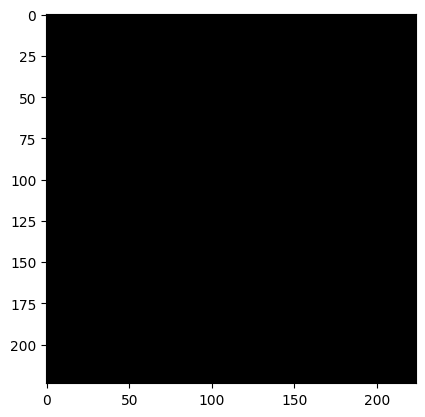

In [44]:
from einops import rearrange
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
sample = next(iter(dataloader))
sample = einops.rearrange(sample, 'f b c w h -> (f b) c w h')
print("sample shape", sample.shape)
plt.imshow(sample[0, 0, :, :], cmap='gray')

In [45]:
print("sample max", sample.max())
print("sample min", sample.min())

sample max tensor(-0.9994)
sample min tensor(-1.)


In [40]:
for batch in dataloader:
    pixel_values = batch
    print(pixel_values.shape)
    

Loading data/mfxl1025422_r0309_peaknet.0000.zarr/images
min before normalization 0.0 max before normalization 65535.0
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1025422_r0309_peaknet.0002.zarr/images
min before normalization 0.0 max before normalization 65535.0
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1025422_r0309_peaknet.0001.zarr/images
min before normalization 0.0 max before normalization 65535.0
torch.Size([1, 40, 3, 224, 224])


### Model Instantiation

In [11]:
# Load the autoencoder model.
device = get_device()
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"
vae = AutoencoderKL.from_single_file(url)
# vae.train()  # Set model to training mode.
vae.eval()
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [12]:
image_np = downsampled_np_avg  # 你的图像结果

# 转换成 tensor，并加 batch 和 channel 维度
image_tensor = torch.from_numpy(image_np).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, 240, 240)

# 如果 VAE 要求 RGB 输入，复制通道到 3 个
image_tensor = image_tensor.repeat(1, 3, 1, 1)  # shape: (1, 3, 240, 240)

# 放到 GPU 或 CPU
image_tensor = image_tensor.to(device).float()

with torch.no_grad():
    # 编码：压缩成 latent 表达
    latent = vae.encode(image_tensor).latent_dist.sample()

    # 解码：重构图像
    reconstructed = vae.decode(latent).sample


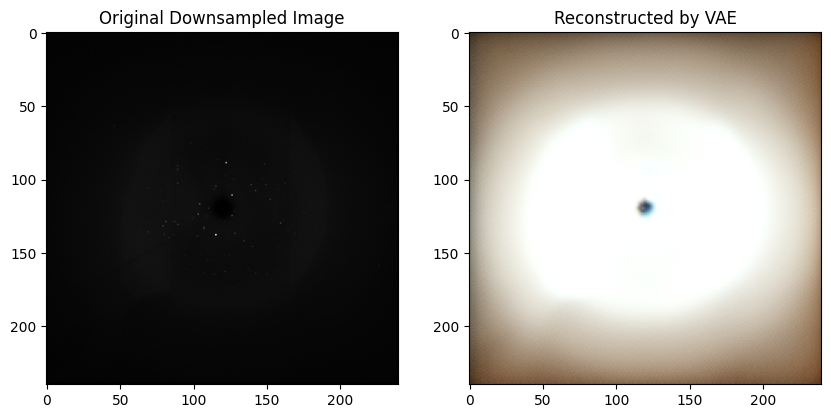

In [14]:
# 取出重构图，去掉 batch 维度
reconstructed_img = reconstructed[0].cpu().numpy().transpose(1, 2, 0)  # shape: (H, W, C)

# 显示
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np, cmap='gray')
plt.title("Original Downsampled Image")
plt.subplot(1, 2, 2)
plt.imshow(np.clip(reconstructed_img, 0, 1), cmap='gray')
plt.title("Reconstructed by VAE")
plt.show()
